<a class="anchor" id="0.1"></a>
# **Table of Contents** 


1.	[Introduction](#1)
2.	[Exponential smoothing](#2)
3.	[Estimating ETS models](#3)
4.	[Model selection](#4)
5.	[Installing Statsforecast](#5)
6.	[Loading libraries and data](#6)
7.	[Explore Data with the plot method](#7)
8.	[Split the data into training and testing](#8)
9.	[Implementation of AutoETS with StatsForecast](#9)
10.	[Accuracy Metrics for Time Series Forecast](#10)
11. [References](#11)

# **1. Introduction** <a class="anchor" id="1"></a>

[Table of Contents](#0.1)

Automatic forecasts of large numbers of univariate time series are often needed in business. It is common to have over one thousand product lines that need forecasting at least monthly. Even when a smaller number of forecasts are required, there may be nobody suitably trained in the use of time series models to produce them. In these circumstances, an automatic forecasting algorithm is an essential tool. Automatic forecasting algorithms must determine an appropriate time series model, estimate the parameters and compute the forecasts. They must be robust to unusual time series patterns, and applicable to large numbers of series without user intervention. The most popular automatic forecasting algorithms are based on either exponential smoothing or ARIMA models.


# **2. Exponential smoothing** <a class="anchor" id="2"></a>

[Table of Contents](#0.1)

Although exponential smoothing methods have been around since the 1950s, a modelling framework incorporating procedures for model selection was not developed until relatively recently. `Ord, Koehler`, and `Snyder (1997), Hyndman, Koehler, Snyder, and Grose (2002)` and `Hyndman, Koehler, Ord`, and `Snyder (2005b)` have shown that all exponential smoothing methods (including non-linear methods) are optimal forecasts from innovations state space models.

Exponential smoothing methods were originally classified by `Pegels’ (1969) taxonomy`. This was later extended by `Gardner (1985), modified by Hyndman et al. (2002)`, and extended again by `Taylor (2003)`, giving a total of fifteen methods seen in the following table.

|    Trend Component |     Seasonal Component|
|----------------|------------------| 

|Component|N(None))|A (Additive)|M (Multiplicative)|
|---------------|--------|------------|------------------|
|N (None)| (N,N) |(N,A) |(N,M)|
|A (Additive)| (A,N)|  (A,A) |  (A,M)|
|Ad (Additive damped)| (Ad,N)| (Ad,A)| (Ad,M)|
|M (Multiplicative)| (M,N )| (M,A )| (M,M)|
|Md (Multiplicative damped)| (Md,N )| ( Md,A)|  (Md,M)|


Some of these methods are better known under other names. For example, cell `(N,N)` describes the **simple exponential smoothing (or SES) method**, cell `(A,N)` describes **Holt’s linear method**, and cell `(Ad,N)` describes **the damped trend method**. The **additive Holt-Winters’ method** is given by cell `(A,A)` and the **multiplicative Holt-Winters’ method** is given by cell `(A,M)`. The other cells correspond to less commonly used but analogous methods.


  

## **2.1 Point forecasts for all methods**

We denote the observed time series by $y_1,y_2,...,y_n$. A forecast of $y_{t+h}$ based on all of the data up to time $t$ is denoted by $\hat y_{t+h|t}$. To illustrate the method, we give the point forecasts and updating equation for method `(A,A)`, the he Holt-Winters’ additive method:

\begin{align*}
  Level: \ell_{t} &= \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1}) \tag{1a} \\
  Growth: b_{t} &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1} \tag{1b} \\
  Seasonal: s_{t} &= \gamma (y_{t}-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m},\tag{1c} \\
  Forecast:\hat{y}_{t+h|t} &= \ell_{t} + hb_{t} + s_{t+h-m(k+1)} \tag{1d} \\
\end{align*}

where $m$ is the length of seasonality (e.g., the number of months or quarters in a year), $ \ell_{t}$ represents the level of the series, $b_t$ denotes the growth, $s_t$ is the seasonal component, $\hat y_{t+h|t}$ is the forecast for $h$ periods ahead, and $h_{m}^{+} = [(h − 1) mod \ m] + 1$. To use method (1), we need values for the initial states $\ell_{0}$, $b_0$ and $s_{1−m}, . . . , s_0$, and for the smoothing parameters $\alpha, \beta^{*}$ and $\gamma$. All of these will be estimated from the observed data.

Equation (1c) is slightly different from the usual Holt-Winters equations such as those in Makridakis et al. (1998) or Bowerman, O’Connell, and Koehler (2005). These authors replace (1c) with
$$s_{t} = \gamma^* (y_{t}-\ell_{t})+ (1-\gamma^*)s_{t-m}.$$

If $\ell_{t}$ is substituted using (1a), we obtain

$$s_{t} = \gamma^*(1-\alpha) (y_{t}-\ell_{t-1}-b_{t-1})+ [1-\gamma^*(1-\alpha)]s_{t-m},$$

Thus, we obtain identical forecasts using this approach by replacing $\gamma$ in (1c) with $\gamma^{*} (1-\alpha) $. The modification given in (1c) was proposed by Ord et al. (1997) to make the state space formulation simpler. It is equivalent to Archibald’s (1990) variation of the Holt-Winters’ method.

## **2.2. Innovations state space models**

For each exponential smoothing method in [Other ETS models](https://otexts.com/fpp3/ets.html) , Hyndman et al. (2008b) describe two possible innovations state space models, one corresponding to a model with additive errors and the other to a model with multiplicative errors. If the same parameter values are used, these two models give equivalent point forecasts, although different prediction intervals. Thus there are 30 potential models described in this classification.

Historically, the nature of the error component has often been ignored, because the distinction between additive and multiplicative errors makes no difference to point forecasts.

We are careful to distinguish exponential smoothing methods from the underlying state space models. An exponential smoothing method is an algorithm for producing point forecasts only. The underlying stochastic state space model gives the same point forecasts, but also provides a framework for computing prediction intervals and other properties.

To distinguish the models with additive and multiplicative errors, we add an extra letter to the front of the method notation. The triplet `(E,T,S)` refers to the three components: error, trend and seasonality. So the model `ETS(A,A,N)` has additive errors, additive trend and no seasonality—in other words, this is Holt’s linear method with additive errors. Similarly, `ETS(M,Md,M)` refers to a model with multiplicative errors, a damped multiplicative trend and multiplicative seasonality. The notation `ETS(·,·,·)` helps in remembering the order in which the components are specified.

Once a model is specified, we can study the probability distribution of future values of the series and find, for example, the conditional mean of a future observation given knowledge of the past. We denote this as $\mu_{t+h|t} = E(y_{t+h | xt})$, where xt contains the unobserved components such as $\ell_t$, $b_t$ and $s_t$. For $h = 1$ we use $\mu_t ≡ \mu_{t+1|t}$ as a shorthand notation. For many models, these conditional means will be identical to the point forecasts given in Table [Other ETS models](https://otexts.com/fpp3/ets.html), so that $\mu_{t+h|t} = \hat y_{t+h|t}$. However, for other models (those with multiplicative trend or multiplicative seasonality), the conditional mean and the point forecast will differ slightly for $h ≥ 2$.

We illustrate these ideas using the damped trend method of Gardner and McKenzie (1985).

Each model consists of a measurement equation that describes the observed data, and some state equations that describe how the unobserved components or states (level, trend, seasonal) change over time. Hence, these are referred to as state space models.

For each method there exist two models: one with additive errors and one with multiplicative errors. The point forecasts produced by the models are identical if they use the same smoothing parameter values. They will, however, generate different prediction intervals.

To distinguish between a model with additive errors and one with multiplicative errors (and also to distinguish the models from the methods), we add a third letter to the classification of in the above Table. We label each state space model as `ETS(⋅,.,.)` for (Error, Trend, Seasonal). This label can also be thought of as ExponenTial Smoothing. Using the same notation as in the above Table, the possibilities for each component (or state) are: `Error ={ A,M }`, `Trend  ={N,A,Ad}` and `Seasonal  ={ N,A,M }`.

### **ETS(A,N,N): simple exponential smoothing with additive errors**
Recall the component form of simple exponential smoothing:

\begin{align*}
  \text{Forecast equation}  && \hat{y}_{t+1|t} & = \ell_{t}\\
  \text{Smoothing equation} && \ell_{t}        & = \alpha y_{t} + (1 - \alpha)\ell_{t-1}.
\end{align*}

If we re-arrange the smoothing equation for the level, we get the “error correction” form,

\begin{align*}
\ell_{t} %&= \alpha y_{t}+\ell_{t-1}-\alpha\ell_{t-1}\\
         &= \ell_{t-1}+\alpha( y_{t}-\ell_{t-1})\\
         &= \ell_{t-1}+\alpha e_{t},
\end{align*}

where $e_{t}=y_{t}-\ell_{t-1}=y_{t}-\hat{y}_{t|t-1}$ s the residual at time $t$.

The training data errors lead to the adjustment of the estimated level throughout the smoothing process for $t=1,\dots,T$. For example, if the error at time $t$ is negative, then $y_t < \hat{y}_{t|t-1}$ and so the level at time $t-1$ has been over-estimated. The new level $\ell_{t}$ is then the previous level $\ell_{t-1}$ adjusted downwards. The closer $\alpha$ is to one, the “rougher” the estimate of the level (large adjustments take place). The smaller the $\alpha$, the “smoother” the level (small adjustments take place).

We can also write $y_t = \ell_{t-1} + e_t$, so that each observation can be represented by the previous level plus an error. To make this into an innovations state space model, all we need to do is specify the probability distribution for $e_t$. For a model with additive errors, we assume that residuals (the one-step training errors) $e_t$ are normally distributed white noise with mean 0 and variance $\sigma^2$. A short-hand notation for this is $e_t = \varepsilon_t\sim\text{NID}(0,\sigma^2)$; NID stands for “normally and independently distributed”.

Then the equations of the model can be written as

\begin{align}
  y_t &= \ell_{t-1} + \varepsilon_t \tag{2}\\
  \ell_t&=\ell_{t-1}+\alpha \varepsilon_t. \tag{3}
\end{align}

We refer to (2) as the measurement (or observation) equation and (3) as the state (or transition) equation. These two equations, together with the statistical distribution of the errors, form a fully specified statistical model. Specifically, these constitute an innovations state space model underlying simple exponential smoothing.

The term “innovations” comes from the fact that all equations use the same random error process, $\varepsilon_t$. For the same reason, this formulation is also referred to as a “single source of error” model. There are alternative multiple source of error formulations which we do not present here.

The measurement equation shows the relationship between the observations and the unobserved states. In this case, observation $y_t$ is a linear function of the level $\ell_{t-1}$, the predictable part of $y_t$, and the error $\varepsilon_t$, the unpredictable part of $y_t$. For other innovations state space models, this relationship may be nonlinear.

The state equation shows the evolution of the state through time. The influence of the smoothing parameter $\alpha$ is the same as for the methods discussed earlier. For example, $\alpha$ governs the amount of change in successive levels: high values of $\alpha$ allow rapid changes in the level; low values of $\alpha$ lead to smooth changes. If $\alpha=0$, the level of the series does not change over time; if $\alpha=1$, the model reduces to a random walk model, $y_t=y_{t-1}+\varepsilon_t$.


### **ETS(M,N,N): simple exponential smoothing with multiplicative errors**

In a similar fashion, we can specify models with multiplicative errors by writing the one-step-ahead training errors as relative errors

$$\varepsilon_t = \frac{y_t-\hat{y}_{t|t-1}}{\hat{y}_{t|t-1}}$$

where $\varepsilon_t \sim \text{NID}(0,\sigma^2)$. Substituting $\hat{y}_{t|t-1}=\ell_{t-1}$ gives $y_t = \ell_{t-1}+\ell_{t-1}\varepsilon_t$ and $e_t = y_t - \hat{y}_{t|t-1} = \ell_{t-1}\varepsilon_t$.

Then we can write the multiplicative form of the state space model as

\begin{align*}
  y_t&=\ell_{t-1}(1+\varepsilon_t)\\
  \ell_t&=\ell_{t-1}(1+\alpha \varepsilon_t).
\end{align*}

### **ETS(A,A,N): Holt’s linear method with additive errors**
For this model, we assume that the one-step-ahead training errors are given by 

$$\varepsilon_t=y_t-\ell_{t-1}-b_{t-1} \sim \text{NID}(0,\sigma^2)$$

Substituting this into the error correction equations for Holt’s linear method we obtain

\begin{align*}
y_t&=\ell_{t-1}+b_{t-1}+\varepsilon_t\\
\ell_t&=\ell_{t-1}+b_{t-1}+\alpha \varepsilon_t\\
b_t&=b_{t-1}+\beta \varepsilon_t,
\end{align*}

where for simplicity we have set $\beta=\alpha \beta^*$.

### **ETS(M,A,N): Holt’s linear method with multiplicative errors**

Specifying one-step-ahead training errors as relative errors such that

$$\varepsilon_t=\frac{y_t-(\ell_{t-1}+b_{t-1})}{(\ell_{t-1}+b_{t-1})}$$

and following an approach similar to that used above, the innovations state space model underlying Holt’s linear method with multiplicative errors is specified as

\begin{align*}
y_t&=(\ell_{t-1}+b_{t-1})(1+\varepsilon_t)\\
\ell_t&=(\ell_{t-1}+b_{t-1})(1+\alpha \varepsilon_t)\\
b_t&=b_{t-1}+\beta(\ell_{t-1}+b_{t-1}) \varepsilon_t,
\end{align*}

where again $\beta=\alpha \beta^*$ and $\varepsilon_t \sim \text{NID}(0,\sigma^2)$.


# **3. Estimating ETS models** <a class="anchor" id="3"></a>

[Table of Contents](#0.1)

An alternative to estimating the parameters by minimising the sum of squared errors is to maximise the “likelihood”. The likelihood is the probability of the data arising from the specified model. Thus, a large likelihood is associated with a good model. For an additive error model, maximising the likelihood (assuming normally distributed errors) gives the same results as minimising the sum of squared errors. However, different results will be obtained for multiplicative error models. In this section, we will estimate the smoothing parameters $\alpha, \beta, \gamma$ and $\phi$ and the initial states $\ell_0, b_0, s_0,s_{-1},\dots,s_{-m+1}$, by maximising the likelihood.

The possible values that the smoothing parameters can take are restricted. Traditionally, the parameters have been constrained to lie between 0 and 1 so that the equations can be interpreted as weighted averages. That is, $0< \alpha,\beta^*,\gamma^*,\phi<1$. For the state space models, we have set $\beta=\alpha\beta^*$ and $\gamma=(1-\alpha)\gamma^*$. Therefore, the traditional restrictions translate to $0< \alpha <1, 0 < \beta < \alpha$ and $0< \gamma < 1-\alpha$. In practice, the damping parameter $\phi$ is usually constrained further to prevent numerical difficulties in estimating the model. 

Another way to view the parameters is through a consideration of the mathematical properties of the state space models. The parameters are constrained in order to prevent observations in the distant past having a continuing effect on current forecasts. This leads to some admissibility constraints on the parameters, which are usually (but not always) less restrictive than the traditional constraints region `(Hyndman et al., 2008, pp. 149–161)`. For example, for the `ETS(A,N,N)` model, the traditional parameter region is $0< \alpha <1$ but the admissible region  is $0< \alpha <2$. For the `ETS(A,A,N)` model, the traditional parameter region is $0<\alpha<1$ and $0<\beta<\alpha$ but the admissible region is $0<\alpha<2$ and $0<\beta<4-2\alpha$.


# **4. Model selection** <a class="anchor" id="4"></a>

[Table of Contents](#0.1)

A great advantage of the `ETS` statistical framework is that information criteria can be used for model selection. The `AIC, AIC_c` and `BIC`, can be used here to determine which of the `ETS` models is most appropriate for a given time series.

For `ETS` models, Akaike’s Information Criterion (`AIC)` is defined as

$$\text{AIC} = -2\log(L) + 2k,$$

where $L$ is the likelihood of the model and $k$ is the total number of parameters and initial states that have been estimated (including the residual variance).

The `AIC` corrected for small sample bias `(AIC_c)` is defined as


$$AIC_c = AIC + \frac{2k(k+1)}{T-k-1}$$

and the Bayesian Information Criterion `(BIC)` is

$$\text{BIC} = \text{AIC} + k[\log(T)-2]$$

Three of the combinations of (Error, Trend, Seasonal) can lead to numerical difficulties. Specifically, the models that can cause such instabilities are `ETS(A,N,M), ETS(A,A,M)`, and `ETS(A,Ad,M)`, due to division by values potentially close to zero in the state equations. We normally do not consider these particular combinations when selecting a model.

Models with multiplicative errors are useful when the data are strictly positive, but are not numerically stable when the data contain zeros or negative values. Therefore, multiplicative error models will not be considered if the time series is not strictly positive. In that case, only the six fully additive models will be applied.

# **5. Installing Statsforecast** <a class="anchor" id="5"></a>

[Table of Contents](#0.1)

* using pip:

`pip install statsforecast`

* using with conda:

`conda install -c conda-forge statsforecast`

¡Warning!

We are constantly updating StatsForecast, so we suggest fixing the version to avoid issues. 

`pip install statsforecast=="1.0.0"`

# **6. Loading libraries and data** <a class="anchor" id="6"></a>

[Table of Contents](#0.1)

In [1]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd

# Hide warnings
# ==============================================================================
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
import plotly.graph_objects as go
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)
# Define the plot size
# ==============================================================================
from pylab import rcParams
rcParams['figure.figsize'] = (18,7)


## Data

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/Esperanza_vida.csv", usecols=[1,2])
df.head()

,year,value
0,1960-01-01,69.123902
1,1961-01-01,69.760244
2,1962-01-01,69.149756
3,1963-01-01,69.248049
4,1964-01-01,70.311707


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [4]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,1960-01-01,69.123902,1
1,1961-01-01,69.760244,1
2,1962-01-01,69.149756,1
3,1963-01-01,69.248049,1
4,1964-01-01,70.311707,1


Now, let's now check the last few rows of our time series using the `.tail()` function.

In [49]:
df.tail()

,ds,y,unique_id
55,2015-01-01,82.543902,1
56,2016-01-01,83.243902,1
57,2017-01-01,82.946341,1
58,2018-01-01,83.346341,1
59,2019-01-01,83.197561,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ds         60 non-null     object 
 1   y          60 non-null     float64
 2   unique_id  60 non-null     object 
dtypes: float64(1), object(2)
memory usage: 1.5+ KB


We can see that our time variable (ds) is in an object format, we need to convert to a date format

In [5]:
# Convert to a datetime format
from datetime import datetime
df["ds"] = pd.to_datetime(df["ds"])

# **7. Explore Data with the plot method** <a class="anchor" id="7"></a>

[Table of Contents](#0.1)

In [6]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

## **7.1 Autocorrelation plots**

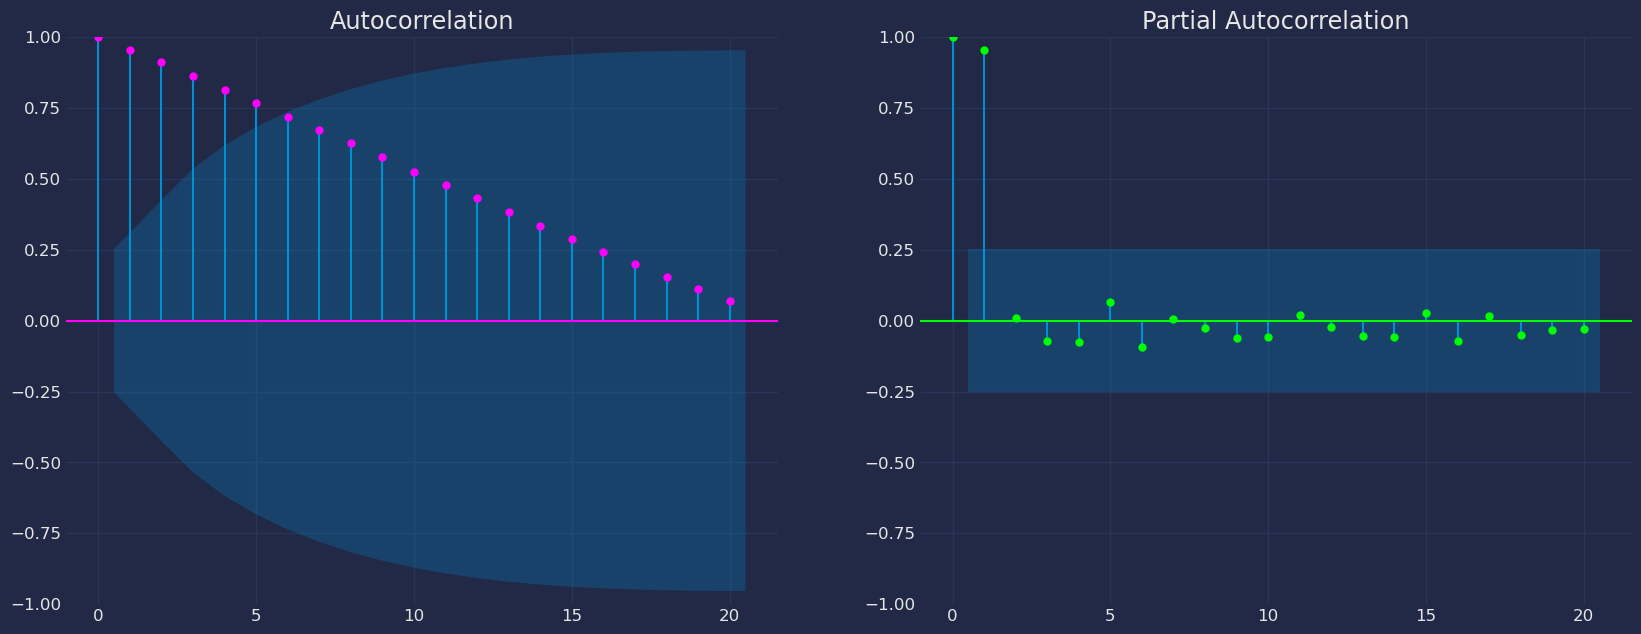

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=20, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

# Plot
plot_pacf(df["y"],  lags=20, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

## **7.2 Decomposition of the time series**

How to decompose a time series and why?

In time series analysis to forecast new values, it is very important to know past data. More formally, we can say that it is very important to know the patterns that values follow over time. There can be many reasons that cause our forecast values to fall in the wrong direction. Basically, a time series consists of four components. The variation of those components causes the change in the pattern of the time series. These components are:

* **Level:** This is the primary value that averages over time.
* **Trend:** The trend is the value that causes increasing or decreasing patterns in a time series.
* **Seasonality:** This is a cyclical event that occurs in a time series for a short time and causes short-term increasing or decreasing patterns in a time series.
* **Residual/Noise:** These are the random variations in the time series.

Combining these components over time leads to the formation of a time series. Most time series consist of level and noise/residual and trend or seasonality are optional values.

If seasonality and trend are part of the time series, then there will be effects on the forecast value. As the pattern of the forecasted time series may be different from the previous time series.

The combination of the components in time series can be of two types:
* Additive
* multiplicative

### Additive time series

If the components of the time series are added to make the time series. Then the time series is called the additive time series. By visualization, we can say that the time series is additive if the increasing or decreasing pattern of the time series is similar throughout the series. The mathematical function of any additive time series can be represented by:
$$y(t) = level + Trend + seasonality + noise$$

### Multiplicative time series

If the components of the time series are multiplicative together, then the time series is called a multiplicative time series. For visualization, if the time series is having exponential growth or decline with time, then the time series can be considered as the multiplicative time series. The mathematical function of the multiplicative time series can be represented as.

$$y(t) = Level * Trend * seasonality * Noise$$

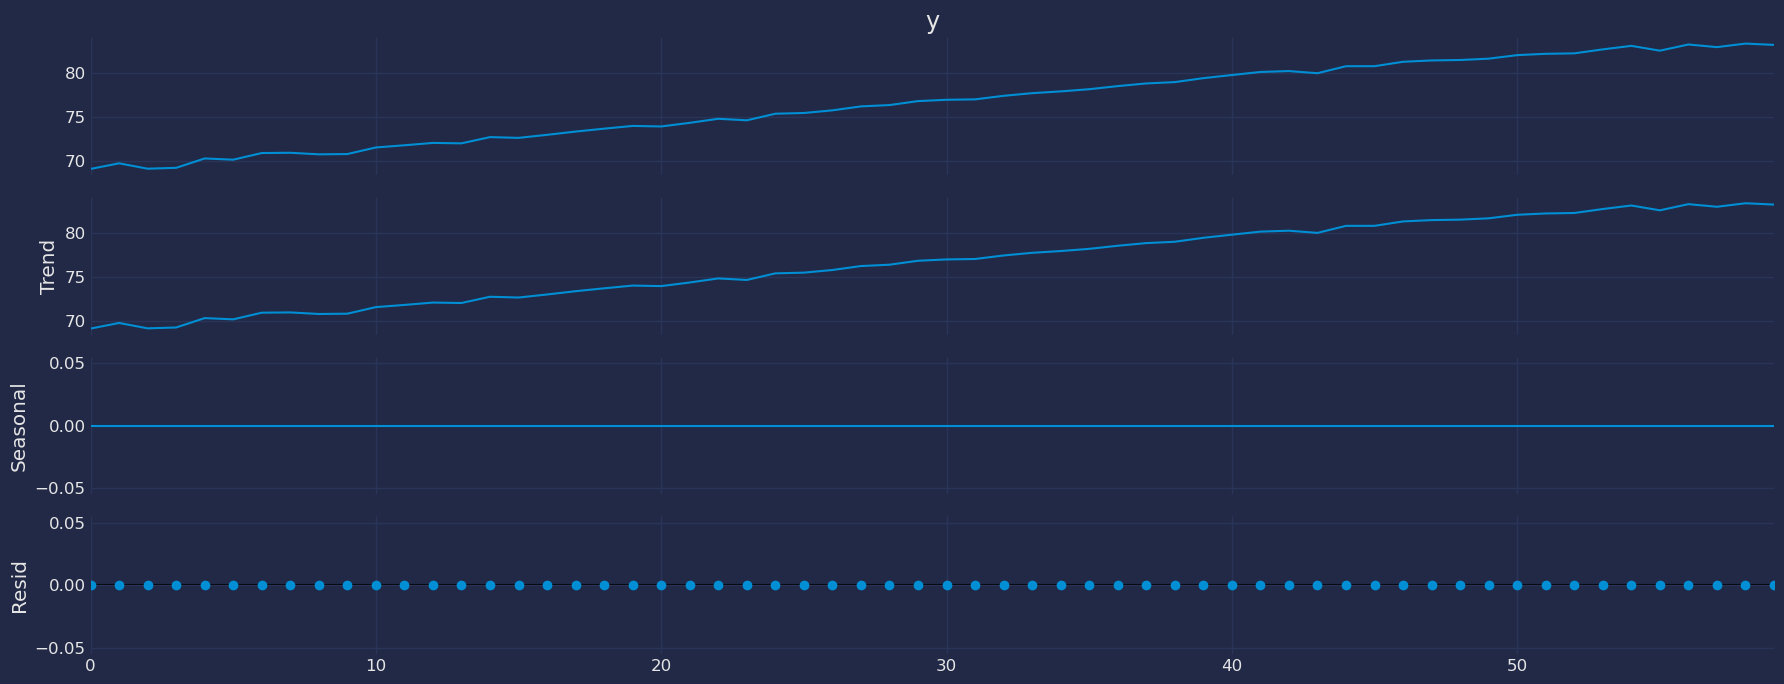

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(df["y"], model = "add", period=1)
a.plot();

Breaking down a time series into its components helps us to identify the behavior of the time series we are analyzing. In addition, it helps us to know what type of models we can apply, for our example of the Life expectancy data set, we can observe that our time series shows an increasing trend throughout the year, on the other hand, it can be observed also that the time series has no seasonality.

By looking at the previous graph and knowing each of the components, we can get an idea of which model we can apply:
* We have trend
* There is no seasonality

# **8. Split the data into training and testing** <a class="anchor" id="8"></a>

[Table of Contents](#0.1)

Let's divide our data into sets
1. Data to train our `AutoETS` model
2. Data to test our model

For the test data we will use the last 6 years to test and evaluate the performance of our model.

In [9]:
train = df[df.ds<='2013-01-01'] 
test = df[df.ds>'2013-01-01'] 

In [10]:
train.shape, test.shape

((54, 3), (6, 3))

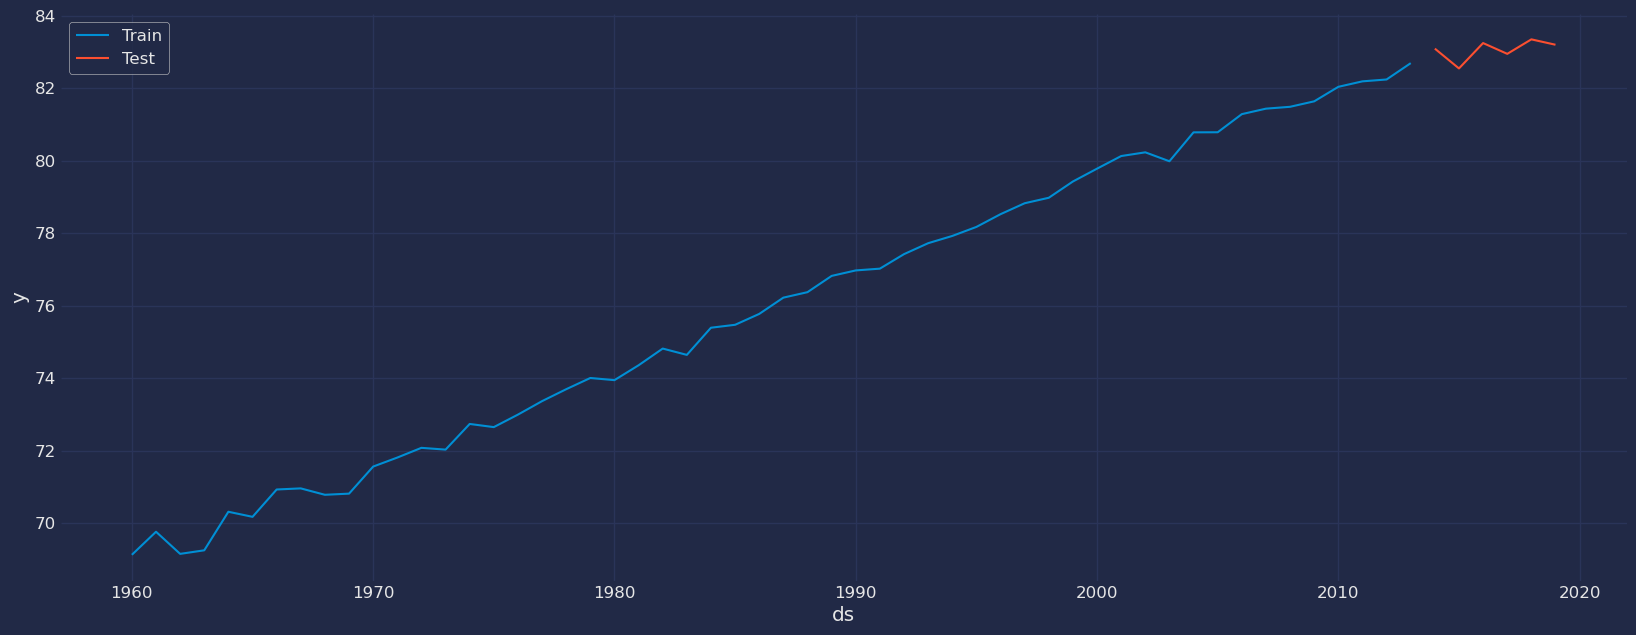

In [11]:
sns.lineplot(train,x="ds", y="y", label="Train")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.show()

# **9. Implementation of AutoETS with StatsForecast** <a class="anchor" id="9"></a>

[Table of Contents](#0.1)

Automatic Exponential Smoothing model.

Automatically selects the best `ETS (Error, Trend, Seasonality)` model using an information criterion. Default is Akaike Information Criterion (AICc), while particular models are estimated using maximum likelihood. The state-space equations can be determined based on their $M$ multiplicative $A$ additive,  $Z$ optimized or $N$ ommited components. The model string parameter defines the ETS equations: $E$ in $[M,A,Z]$, $T$ in $[N,A,M,Z]$, and $S$ in $[N,A,M,Z]$.

For example when `model=‘ANN’` (additive error, no trend, and no seasonality), `ETS` will explore only a simple exponential smoothing.

If the component is selected as `‘Z’`, it operates as a placeholder to ask the `AutoETS` model to figure out the best parameter.

In [13]:
# Load librarie

from statsforecast.models import AutoETS


#  Building model
autoets = AutoETS(model=["A","Z","N"],  alias="AutoETS", season_length=1)


To know other parameters that the model has, you can consult [here](https://nixtla.github.io/statsforecast/src/core/models.html#autoets)

### **9.1 Fit the Model**

In [14]:
autoets = autoets.fit(df["y"].values)
autoets

AutoETS

### **9.2 Predict Model**

In [15]:
y_hat_dict = autoets.predict(h=6)
y_hat_dict

{'mean': array([83.56937105, 83.65696041, 83.74454977, 83.83213913, 83.91972848,
        84.00731784])}

You can see that the result that has been extracted in the predictions or in any other method that we use from now on with the Arima model is a dictionary. To extract that result we can use the `.get()` function, which will help us to be able to extract the result of each part of the dictionary of each of the methods that we use.

In [16]:
forecast=pd.Series(pd.date_range("2014-01-01", freq="ys", periods=6))
forecast=pd.DataFrame(forecast)
forecast.columns=["ds"]
forecast["hat"]=y_hat_dict.get("mean")
forecast["unique_id"]="1"
forecast

,ds,hat,unique_id
0,2014-01-01,83.569371,1
1,2015-01-01,83.656960,1
2,2016-01-01,83.744550,1
3,2017-01-01,83.832139,1
4,2018-01-01,83.919728,1
5,2019-01-01,84.007318,1


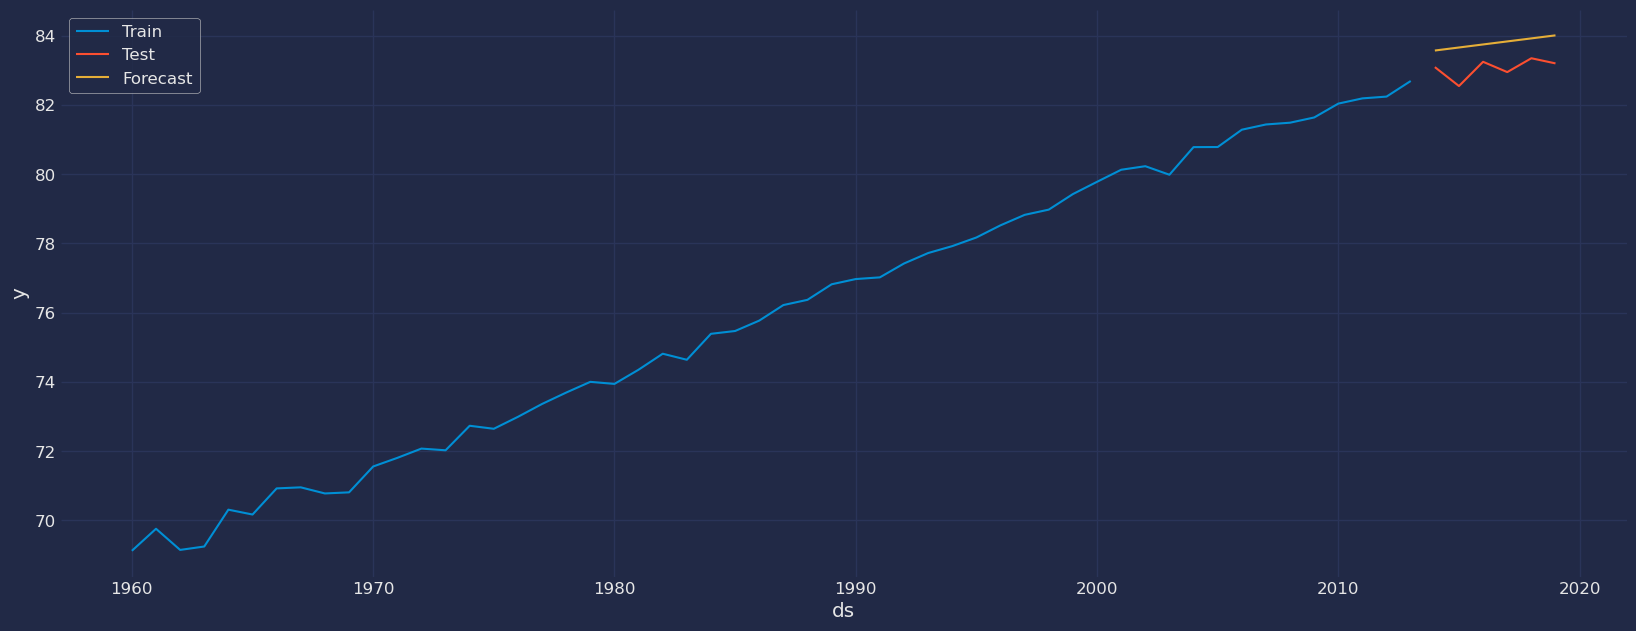

In [17]:
sns.lineplot(train,x="ds", y="y", label="Train")
sns.lineplot(test, x="ds", y="y", label="Test")
sns.lineplot(forecast,x="ds", y="hat", label="Forecast",)
plt.show()

Let's add a confidence interval to our forecast.

In [18]:
y_hat_dict = autoets.predict(h=6, level=[80,90,95])
y_hat_dict

{'mean': array([83.56937105, 83.65696041, 83.74454977, 83.83213913, 83.91972848,
        84.00731784]),
 'lo-95': array([83.09409059, 83.17958519, 83.25889648, 83.32836493, 83.3852606 ,
        83.42814393]),
 'lo-90': array([83.17050311, 83.2563345 , 83.33697668, 83.40935849, 83.4711889 ,
        83.52125977]),
 'lo-80': array([83.25860186, 83.34482153, 83.42699815, 83.50273889, 83.57025872,
        83.62861638]),
 'hi-80': array([83.88014025, 83.96909929, 84.06210139, 84.16153937, 84.26919825,
        84.38601931]),
 'hi-90': array([83.96823899, 84.05758633, 84.15212286, 84.25491976, 84.36826807,
        84.49337591]),
 'hi-95': array([84.04465152, 84.13433563, 84.23020306, 84.33591332, 84.45419637,
        84.58649176])}

In [19]:
forecast["hat"]=y_hat_dict.get("mean")
#
forecast["lo-80"]=y_hat_dict.get("lo-80")
forecast["hi-80"]=y_hat_dict.get("hi-80")
#
forecast["lo-90"]=y_hat_dict.get("lo-80")
forecast["hi-90"]=y_hat_dict.get("hi-80")
#
forecast["lo-95"]=y_hat_dict.get("lo-95")
forecast["hi-95"]=y_hat_dict.get("hi-95")
forecast

,ds,hat,unique_id,lo-80,hi-80,lo-90,hi-90,lo-95,hi-95
0,2014-01-01,83.569371,1,83.258602,83.880140,83.258602,83.880140,83.094091,84.044652
1,2015-01-01,83.656960,1,83.344822,83.969099,83.344822,83.969099,83.179585,84.134336
2,2016-01-01,83.744550,1,83.426998,84.062101,83.426998,84.062101,83.258896,84.230203
3,2017-01-01,83.832139,1,83.502739,84.161539,83.502739,84.161539,83.328365,84.335913
4,2018-01-01,83.919728,1,83.570259,84.269198,83.570259,84.269198,83.385261,84.454196
5,2019-01-01,84.007318,1,83.628616,84.386019,83.628616,84.386019,83.428144,84.586492


In [20]:
df=df.set_index("ds")
forecast=forecast.set_index("ds")

In [21]:
df_plot=df.merge(forecast, how='left', on=['unique_id', 'ds'])


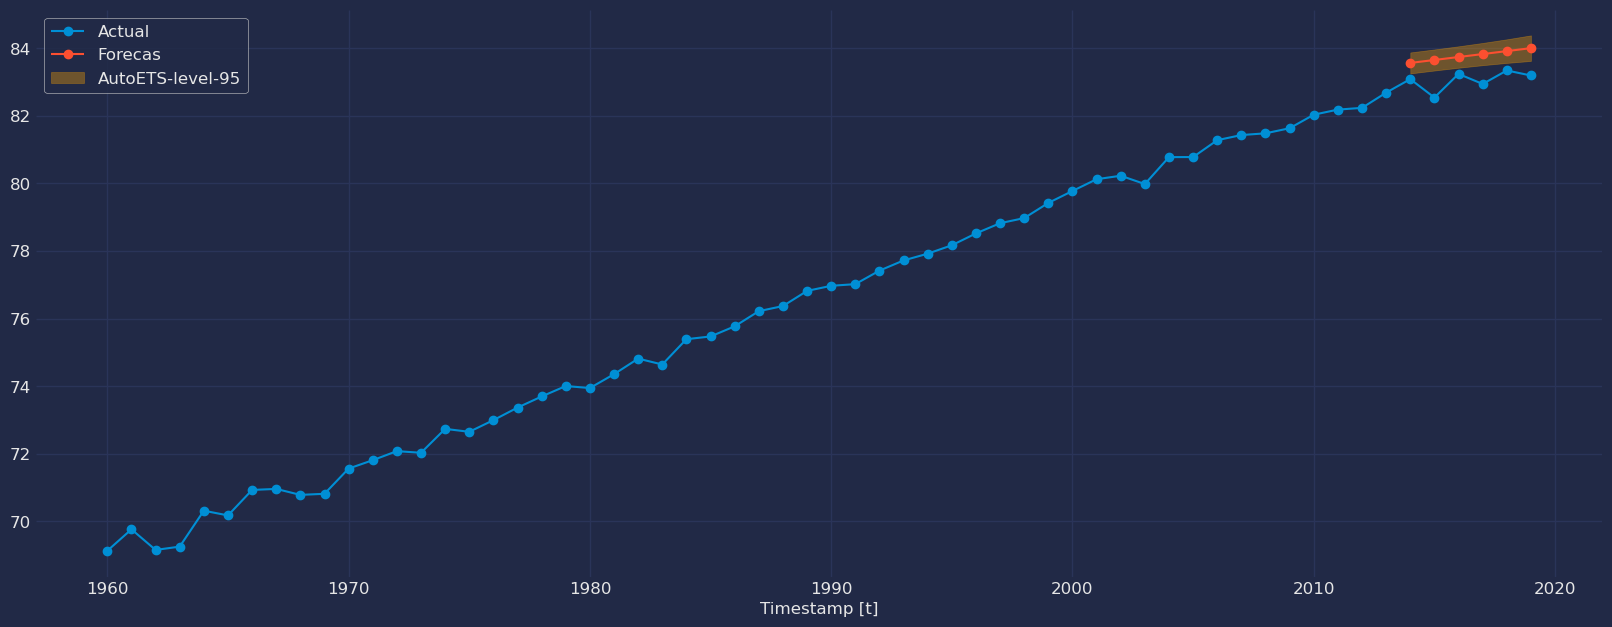

In [22]:
fig, ax = plt.subplots()
plt.plot_date(df_plot.index, df_plot["y"],label="Actual", linestyle="-")
plt.plot_date(df_plot.index, df_plot["hat"],label="Forecas", linestyle="-")
ax.fill_between(df_plot.index, 
                df_plot['lo-80'], 
                df_plot['hi-80'],
                alpha=.35,
                color='orange',
                label='AutoETS-level-95')
ax.set_title('', fontsize=22)
ax.set_ylabel('', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=12)
plt.legend(fontsize=12)
ax.grid(True)

plt.show()

### **9.3 AutoETS.predict_in_sample()**
Access fitted Exponential Smoothing insample predictions.

In [23]:
autoets.predict_in_sample()

{'fitted': array([69.11047128, 69.33779313, 69.60481978, 69.82902341, 69.99867608,
        70.19782129, 70.39447403, 70.6410976 , 70.91730954, 71.18057737,
        71.40921444, 71.65195408, 71.90923238, 72.18210689, 72.44032072,
        72.72619326, 73.00461648, 73.28185885, 73.56688287, 73.86376672,
        74.17369207, 74.4619337 , 74.74004938, 75.02518845, 75.27413727,
        75.53397698, 75.78785822, 76.0401374 , 76.30927822, 76.58417332,
        76.88118063, 77.18657633, 77.47625869, 77.76062769, 78.04136835,
        78.31088961, 78.56725183, 78.81937322, 79.07197167, 79.31551239,
        79.56929831, 79.84269161, 80.14276586, 80.45093604, 80.71510722,
        80.98548038, 81.23680745, 81.49249391, 81.74269063, 81.96870832,
        82.16354077, 82.34648092, 82.51452241, 82.65668891, 82.80204272,
        82.97448067, 83.1064133 , 83.2513209 , 83.36754658, 83.4818162 ])}

### **9.4 AutoETS.forecast method**
Memory Efficient Exponential Smoothing predictions.

This method avoids memory burden due from object storage. It is analogous to fit_predict without storing information. It assumes you know the forecast horizon in advance.

In [24]:
autoets.forecast(y=train["y"].values, h=6, fitted=True)

{'mean': array([82.95334067, 83.14710962, 83.34087858, 83.53464753, 83.72841648,
        83.92218543]),
 'fitted': array([69.00631079, 69.23838078, 69.49672275, 69.73753749, 69.95373373,
        70.18800832, 70.42142612, 70.68026343, 70.95296729, 71.21693197,
        71.46051702, 71.70909162, 71.96257898, 72.22173709, 72.47104279,
        72.73363157, 72.99184677, 73.25007587, 73.5140747 , 73.78708229,
        74.07093074, 74.34832297, 74.62600899, 74.91319459, 75.18661412,
        75.47027994, 75.75394823, 76.03846177, 76.33209228, 76.62765077,
        76.93286853, 77.2399741 , 77.53597227, 77.82612695, 78.11104644,
        78.38645253, 78.6510127 , 78.90909424, 79.16292255, 79.40732528,
        79.65260623, 79.90420341, 80.16700064, 80.43291173, 80.67615301,
        80.92469414, 81.16608469, 81.41337419, 81.66169821, 81.90113913,
        82.12727338, 82.34886657, 82.56235691, 82.75957866])}

In [70]:
autoets.forecast(y=train["y"].values, h=6, fitted=True, level=[95])

{'mean': array([82.95334067, 83.14710962, 83.34087858, 83.53464753, 83.72841648,
        83.92218543]),
 'fitted': array([69.00631079, 69.23838078, 69.49672275, 69.73753749, 69.95373373,
        70.18800832, 70.42142612, 70.68026343, 70.95296729, 71.21693197,
        71.46051702, 71.70909162, 71.96257898, 72.22173709, 72.47104279,
        72.73363157, 72.99184677, 73.25007587, 73.5140747 , 73.78708229,
        74.07093074, 74.34832297, 74.62600899, 74.91319459, 75.18661412,
        75.47027994, 75.75394823, 76.03846177, 76.33209228, 76.62765077,
        76.93286853, 77.2399741 , 77.53597227, 77.82612695, 78.11104644,
        78.38645253, 78.6510127 , 78.90909424, 79.16292255, 79.40732528,
        79.65260623, 79.90420341, 80.16700064, 80.43291173, 80.67615301,
        80.92469414, 81.16608469, 81.41337419, 81.66169821, 81.90113913,
        82.12727338, 82.34886657, 82.56235691, 82.75957866]),
 'lo-95': array([82.50120336, 82.69439921, 82.88588753, 83.07456973, 83.2594347 ,
        83.4

### **9.5 AutoETS.forward method**

In [25]:
autoets.forward(train["y"].values, h=6)

{'mean': array([82.80204272, 82.94739245, 83.09274218, 83.23809191, 83.38344164,
        83.52879137])}

# **10. Accuracy Metrics for Time Series Forecast** <a class="anchor" id="10"></a>

[Table of Contents](#0.1)

The commonly used accuracy metrics to judge forecasts are:

1. Mean Absolute Percentage Error (MAPE)
2. Mean Error (ME)
3. Mean Absolute Error (MAE)
4. Mean Percentage Error (MPE)
5. Root Mean Squared Error (RMSE)
6. Correlation between the Actual and the Forecast (corr)



Typically, we will use three accuracy metrices:-

1. MAPE
2. Correlation 

can be used. The above three are percentage errors that vary between 0 and 1. That way, we can judge how good is the forecast irrespective of the scale of the series.

In [26]:
from sklearn import metrics

In [27]:
def model_evaluation(y_true, y_pred, Model):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print (f'Model Evaluation: {Model}')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}')
    print(f'corr is : {np.corrcoef(y_true, y_pred)[0,1]}',end='\n\n')            
    

In [28]:
model_evaluation(test["y"], forecast["hat"], "AutoETS")

Model Evaluation: AutoETS
MSE is : 0.5813708313516357
MAE is : 0.7269623344336272
RMSE is : 0.7624767743030837
MAPE is : 0.8759446712175776
R2 is : -7.40712893299275
corr is : 0.49104180892284527



# **11. References** <a class="anchor" id="11"></a>


[Table of Contents](#0.1)



1. [Nixtla-Arima](https://nixtla.github.io/statsforecast/src/core/models.html#arima-family)

2. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting principles and practice, Time series cross-validation”.](https://otexts.com/fpp3/tscv.html)
